# Graphical Models: Similarity Distribution Experimentation

In [1]:
# Import necessary libraries
import networkx as nx
from networkx.algorithms import approximation
from networkx.algorithms.approximation import independent_set, clique
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random, itertools as it
from scipy.special import comb
import pandas as pd
import numpy as np

## Similarity Implementations

### General Methods

In [2]:
# get all children in a dictionary including their respective weights (chains taken into account)
def get_all_children(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_all_children(graph, i[1], children_dict=children_dict, carry=weights[i])
    return children_dict

In [3]:
# (Adapted from function above)
# Get all children in a dictionary including their respective weights (chains taken into account)
def get_descendants(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_descendants(graph, i[1], children_dict=children_dict, carry=weights[i])
    
    return children_dict

In [4]:
# Returns children of a single node
def get_children(gm, parent):
    children_weights = {}
    weights = nx.get_edge_attributes(gm, 'weight')
    
    for i in gm.out_edges(parent):
        children_weights[i[1]] = weights[i]

    return children_weights

In [5]:
def find_node_children_subgraph(graph, snode, childgraph):
    cnodes = graph.neighbors(snode)
    edges = nx.edges(graph)
    for i in cnodes:
        childgraph.add_node(i)
        childgraph.add_edge(snode, i)
        childgraph = find_node_children_subgraph(graph, i, childgraph)
    return childgraph

### Jaccard Index

In [6]:
# all children of rain
def calculate_intersection(graph, children_a, children_b):
    inter = 0
    for i in children_a:
        if i in children_b:
            if children_a[i] < children_b[i]:
                inter += children_a[i]
            else:
                inter += children_b[i]
    return inter  

In [7]:
# helper func to calculate the union using method 1
def calculate_union(graph, children_a, children_b):
    union = 0
    
    for i in children_a:
        union += children_a[i]
        
    for i in children_b:
        union += children_b[i]
    
    union -= calculate_intersection(graph, children_a, children_b)
    
    return union

In [8]:
# calculate the similarity, compares both methods
def calculate_similarity(graph, node_a, node_b):
    children_a = get_all_children(graph, node_a, {})
    children_b = get_all_children(graph, node_b, {})
    
    intersection = calculate_intersection(graph, children_a, children_b)
    union = calculate_union(graph, children_a, children_b)
    
    results = 0
    if union != 0:
        results = intersection/union
            
    return results

### Edit-Distance

Edit-distance similarity implementation based only on a node's children.

In [9]:
# Returns the similarity of node B compared to node A, based on children
def get_immediate_similarity(gm, A, B):
    cost = 0.0
    A_children = get_children(gm, A)
    B_children = get_children(gm, B)
    
    if len(A_children) > 0:
        for child in A_children:
            if child in B_children:
                diff = abs(A_children[child] - B_children[child])
                cost += diff
            else:
                cost += 1

        return cost / len(A_children)
    
    else:
        return 0

In [10]:
# Returns the node that is most similar to the input node
def find_most_immediate_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_immediate_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    
    for node in nodes:
        node_similarity = get_immediate_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

Edit-distance similarity implementation based on all descendants of a node.

In [11]:
# Returns the similarity of node B compared to node A
def get_full_similarity(gm, A, B):
    cost = 0.0
    A_children = get_descendants(gm, A, {}, 1)
    B_children = get_descendants(gm, B, {}, 1)
    
    if len(A_children) > 0:
        for child in A_children:
            if child in B_children:
                diff = abs(A_children[child] - B_children[child])
                cost += diff
            else:
                cost += 1
        return 1-(cost / len(A_children))
    else:
        return 1

# Optional print line in for loop for debugging: 
# print(child, A_children[child], B_children[child])

In [12]:
# get_full_similarity(dg, 1, 5)

In [13]:
# dg = nx.DiGraph()
# dg.add_node(1)
# dg.add_node(2)
# dg.add_node(3)
# dg.add_node(4)
# dg.add_node(5)
# dg.add_edge(1, 3, weight=1)
# dg.add_edge(2, 3, weight=1)
# dg.add_edge(3, 4, weight=1)
# dg.add_edge(4, 5, weight=1)

In [14]:
# nx.draw_networkx(dg)

In [15]:
# Returns the node that is most similar to the input node
def find_most_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_full_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_full_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

### NetworkX: Edit-Distance

In [16]:
# nx.graph_edit_distance(Graph1, Graph2)

### NetworkX: SimRank

In [17]:
# nx.algorithms.similarity.simrank_similarity(graph, source="node_a", target="node_b")

## Generating Random Directed Graphs

In [18]:
def addNodes(gm, num_nodes):
    node_list = []
    
    for i in range(num_nodes):
        gm.add_node(i)

    return gm

In [19]:
# NOTE: This function does not have functionality implemented yet that 
# prevents cycles from occurring
def addEdges(gm, num_nodes, num_edges):
    for i in range(num_edges):
        parent = random.randrange(num_nodes)
        child = random.randrange(num_nodes)
        
        conditional_prob = random.uniform(0, 1)
        gm.add_edge(parent, child, weight=conditional_prob)
            
        if not nx.is_directed_acyclic_graph(gm):
            gm.remove_edge(parent, child)
        
    return gm

In [20]:
def makeDirectedGraph(num_nodes, num_edges):
    dg = nx.DiGraph() # creates directed graph
    dg = addNodes(dg, num_nodes)
    dg = addEdges(dg, num_nodes, num_edges)
    return dg

In [21]:
# Randomizes edge weights
def makeDirectedPath(num_nodes):
    pdg = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    for i in pdg.edges():
        pdg.edges[i[0], i[1]]['weight'] = weight=random.uniform(0, 1)
    return pdg

In [22]:
# Sets all edge weights to 1
def makeDirectedPathOne(num_nodes):
    pdg = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    for i in pdg.edges():
        pdg.edges[i[0], i[1]]['weight'] = 1
    return pdg

In [23]:
def makeDirectedStarGraph(num_nodes):
    sdg = nx.DiGraph()
    sdg.add_node(0)
    for i in range(1, num_nodes+1):
        sdg.add_node(i)
        sdg.add_edge(0, i, weight=random.uniform(0, 1))
    return sdg

## Running Experiments

### Distribution of Similarity Over Random Graphs of Constant Size

In [24]:
def getSimilarityData(gm):
    node_list = list(gm.nodes)
    node_pairs = list(it.combinations(node_list, 2))

    ed_imm_sim, ed_full_sim, ji_sim = [], [], []

    for pair in node_pairs:
        ed_imm_sim.append(get_immediate_similarity(gm, pair[0], pair[1]))
        ed_imm_sim.append(get_immediate_similarity(gm, pair[1], pair[0]))

        ed_full_sim.append(get_full_similarity(gm, pair[0], pair[1]))
        ed_full_sim.append(get_full_similarity(gm, pair[1], pair[0]))

        ji_sim.append(calculate_similarity(gm, pair[0], pair[1]))
        ji_sim.append(calculate_similarity(gm, pair[1], pair[0]))

    similarity_data = {"Edit-Distance Immediate Similarity": ed_imm_sim, 
                       "Edit-Distance Full Similarity": ed_full_sim,
                       "Jaccard Index Similarity": ji_sim}
        
    return similarity_data

In [25]:
def getCliqueData(gm):
    node_list = list(gm.nodes)
    num_rows = len(list(it.combinations(node_list, 2))) * 2
    
    longest_max_indep_set = len(independent_set.maximum_independent_set(gm))
    max_cliques = list(clique.clique_removal(gm)[1]) * num_rows
    num_max_cliques = len(max_cliques)
    longest_max_clique = len(max_cliques[0])
    
    clique_data = {"Longest Maximum Independent Set": [longest_max_indep_set] * num_rows,
                   "Number of Maximum Cliques": [num_max_cliques] * num_rows, 
                   "Longest Maximum Clique": [longest_max_clique] * num_rows}
    
    return clique_data

In [26]:
def getGraphSimilarityList(num_graphs, num_nodes, num_edges): 
    graph_sim_list = []
    
    for i in range(num_graphs):
        dg = makeDirectedGraph(num_nodes, num_edges)
        
        similarity_data = getSimilarityData(dg)
        clique_data = getCliqueData(dg) 
        similarity_data.update(clique_data)
                        
        graph_sim = pd.DataFrame(data = similarity_data)
        graph_sim_list.append(graph_sim)
    
    return graph_sim_list

In [27]:
# similarity_dist = getGraphSimilarityList(2, 10, 15)
# similarity_dist

### Condensing Data

In [28]:
column_list = ["Edit-Distance Immediate Similarity", "Edit-Distance Full Similarity", 
                 "Jaccard Index Similarity",
                 "Longest Maximum Independent Set",
                 "Number of Maximum Cliques",
                 "Longest Maximum Clique"]

In [29]:
metrics = ["mean", "50%", "std"]

In [30]:
# def getLists(experiment_data):
#     metric_values = []
    
#     for metric in metrics:
#         ed_imm_sim, ed_full_sim, ji_sim = [], [], []
#         longest_max_ind_set, num_max_cliques, longest_max_clique = [], [], []

#         similarity_lists = [ed_imm_sim, ed_full_sim, ji_sim, longest_max_ind_set,
#                             num_max_cliques, longest_max_clique]

#         for graph_df in experiment_data:
#             summary = graph_df.describe(include = "all")
            
#             for index in range(len(column_list)):
#                 similarity_lists[index].append(summary[column_list[index]][metric])
        
#         metric_values.append(similarity_lists)
    
#     return metric_values

In [31]:
def getGraphSummaryRow(graph_summary): 
    graph_summary_row = []
    
    for column in column_list:
        graph_summary_row.append(graph_summary[column]["mean"])
        graph_summary_row.append(graph_summary[column]["50%"])
        graph_summary_row.append(graph_summary[column]["std"])
    
    return tuple(graph_summary_row)

In [32]:
def getCondensedSimilarityDistribution(graph_dist_list):
    cols = pd.MultiIndex.from_product([column_list, metrics])
    similarity_dist = pd.DataFrame(index = ["Graph Number"], columns = cols)
    
    index = 0
    for graph_similarity in graph_dist_list:
        graph_summary = graph_similarity.describe(include="all")
        graph_summary_row = getGraphSummaryRow(graph_summary)
    
        similarity_dist.loc[index,:] = graph_summary_row
        index += 1
    
    return similarity_dist

In [33]:
# condensed_similarity_dist = getCondensedSimilarityDistribution(similarity_dist)
# condensed_similarity_dist

### Distribution Over Varying Graph Sizes

In [34]:
column_list = ["Edit-Distance Immediate Similarity", "Edit-Distance Full Similarity", 
                 "Jaccard Index Similarity",
                 "Longest Maximum Independent Set",
                 "Number of Maximum Cliques",
                 "Longest Maximum Clique"]

In [35]:
# def getUpdatedColumnList(column_list):
#     updated_column_list = []
    
#     for column in column_list:
#         updated_column_list.append(column + " [Average]")
#         updated_column_list.append(column + " [Median]")
#         updated_column_list.append(column + " [STD]")
    
#     return updated_column_list

In [36]:
nodes_to_edges_factor = 1.5

In [37]:
def getNewRow(graph_distribution): 
    new_row = []
    
    for column in column_list:
        similarities = graph_distribution[column]["mean"]
        new_row.append(similarities.mean())
        new_row.append(similarities.median())
        new_row.append(similarities.std())

    return tuple(new_row)

In [38]:
def getGraphSizeDistribution(num_graphs, start_num_nodes, end_num_nodes, step):    
    cols = pd.MultiIndex.from_product([column_list, metrics])
    graph_size_dist = pd.DataFrame(index = [["Number of Nodes Per Graph"], ["Number of Graphs"]], columns = cols)

    for num_nodes in range(start_num_nodes, end_num_nodes, step):
        num_edges = int(num_nodes * nodes_to_edges_factor)
        
        graph_similarity_list = getGraphSimilarityList(num_graphs, num_nodes, num_edges)
        graph_distribution = getCondensedSimilarityDistribution(graph_similarity_list)
        
        new_row = getNewRow(graph_distribution)
        graph_size_dist.loc[(num_nodes, num_graphs),:] = new_row

    return graph_size_dist

In [39]:
# graph_size_dist = getGraphSizeDistribution(2, 3, 14, 10)
# graph_size_dist

## Exporting Data

In [40]:
# condensed_similarity_dist.to_csv("Data/similarity-distribution.csv", index=True)

In [41]:
# graph_size_dist.to_csv("Data/graph-size-distrubtion-5-10-41-10.csv", index=True)

## Analysis

### Distribution Over Varying Graph Sizes

In [42]:
graph_dist = pd.read_csv("Data/graph-size-distrubtion-5-10-41-10.csv")
graph_dist.head()

,Unnamed: 0,Nodes,Edit-Distance Immediate Similarity,Edit-Distance Full Similarity,Jaccard Index Similarity (Method 1),Jaccard Index Similarity (Method 2),Longest Maximum Independent Set,Number of Maximum Cliques,Longest Maximum Clique,Edit-Distance Immediate Similarity STD,Edit-Distance Full Similarity STD,Jaccard Index Similarity (Method 1) STD,Jaccard Index Similarity (Method 2) STD,Longest Maximum Independent Set STD,Number of Maximum Cliques STD,Longest Maximum Clique STD
0,0,10.0,0.644257,0.510590,0.049877,0.072394,6.4,558.0,2.4,0.082115,0.094458,0.012159,0.023982,0.547723,75.299402,0.547723
1,1,20.0,0.712250,0.445052,0.133981,0.334778,13.2,4636.0,3.0,0.076711,0.023759,0.069368,0.260117,2.167948,169.941166,0.000000
2,2,30.0,0.758761,0.497384,0.109458,0.226572,17.8,15312.0,3.0,0.087241,0.081705,0.043307,0.127783,0.447214,778.151656,0.000000
3,3,40.0,0.742377,0.490881,0.115216,0.268362,25.8,35880.0,2.8,0.022406,0.054423,0.032203,0.116232,2.049390,2466.576575,0.447214


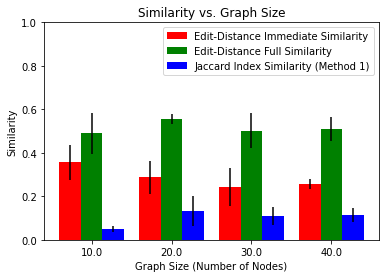

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Adapted from https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

ed_imm_sim = graph_dist["Edit-Distance Immediate Similarity"]
ed_f_sim = graph_dist["Edit-Distance Full Similarity"]
ji_sim = graph_dist["Jaccard Index Similarity (Method 1)"]

ed_imm_sim_std = graph_dist["Edit-Distance Immediate Similarity STD"]
ed_f_sim_std = graph_dist["Edit-Distance Full Similarity STD"]
ji_sim_std = graph_dist["Jaccard Index Similarity (Method 1) STD"]

rects1 = ax.bar(ind, 1 - ed_imm_sim, width, color='r', yerr=ed_imm_sim_std)
rects2 = ax.bar(ind + width, 1 - ed_f_sim, width, color='g', yerr=ed_f_sim_std)
rects3 = ax.bar(ind + width * 2, ji_sim, width, color='b', yerr=ji_sim_std)

ax.set_ylabel('Similarity')
ax.set_xlabel("Graph Size (Number of Nodes)")
ax.set_xticks(ind + width)
ax.set_xticklabels(graph_dist["Nodes"])
ax.legend((rects1[0], rects2[0], rects3[0]), ('Edit-Distance Immediate Similarity', 'Edit-Distance Full Similarity', 'Jaccard Index Similarity (Method 1)'))
ax.set_ylim(0, 1)
ax.set_title("Similarity vs. Graph Size")

plt.show()

#### Other Work

In [44]:
graph_size_dist = pd.read_csv("Data/graph-size-distrubtion-5-10-41-10.csv")

In [45]:
graph_size_dist.head()

,Unnamed: 0,Nodes,Edit-Distance Immediate Similarity,Edit-Distance Full Similarity,Jaccard Index Similarity (Method 1),Jaccard Index Similarity (Method 2),Longest Maximum Independent Set,Number of Maximum Cliques,Longest Maximum Clique,Edit-Distance Immediate Similarity STD,Edit-Distance Full Similarity STD,Jaccard Index Similarity (Method 1) STD,Jaccard Index Similarity (Method 2) STD,Longest Maximum Independent Set STD,Number of Maximum Cliques STD,Longest Maximum Clique STD
0,0,10.0,0.644257,0.510590,0.049877,0.072394,6.4,558.0,2.4,0.082115,0.094458,0.012159,0.023982,0.547723,75.299402,0.547723
1,1,20.0,0.712250,0.445052,0.133981,0.334778,13.2,4636.0,3.0,0.076711,0.023759,0.069368,0.260117,2.167948,169.941166,0.000000
2,2,30.0,0.758761,0.497384,0.109458,0.226572,17.8,15312.0,3.0,0.087241,0.081705,0.043307,0.127783,0.447214,778.151656,0.000000
3,3,40.0,0.742377,0.490881,0.115216,0.268362,25.8,35880.0,2.8,0.022406,0.054423,0.032203,0.116232,2.049390,2466.576575,0.447214


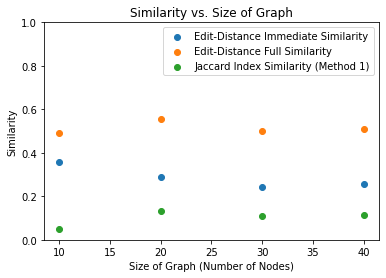

In [46]:
plt.scatter(graph_size_dist["Nodes"], 1 - graph_size_dist["Edit-Distance Immediate Similarity"], label = "Edit-Distance Immediate Similarity")
plt.scatter(graph_size_dist["Nodes"], 1 - graph_size_dist["Edit-Distance Full Similarity"], label = "Edit-Distance Full Similarity")
plt.scatter(graph_size_dist["Nodes"], graph_size_dist["Jaccard Index Similarity (Method 1)"], label = "Jaccard Index Similarity (Method 1)")

plt.xlabel('Size of Graph (Number of Nodes)')
plt.ylabel('Similarity')
plt.title('Similarity vs. Size of Graph')
plt.legend()
plt.rcParams["figure.figsize"] = (10,7)
plt.ylim(0, 1)

plt.show()

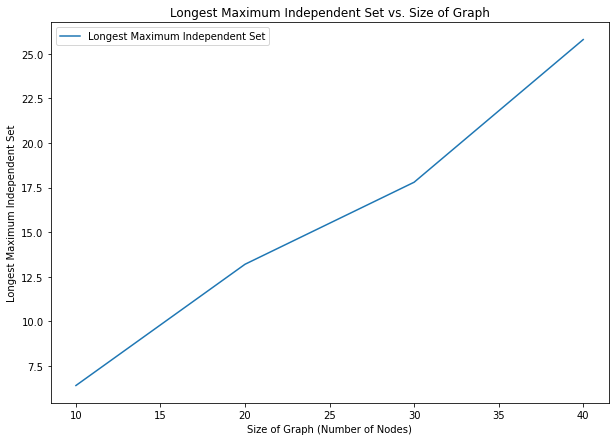

In [47]:
plt.plot(graph_size_dist["Nodes"], graph_size_dist["Longest Maximum Independent Set"], label = "Longest Maximum Independent Set")

plt.xlabel('Size of Graph (Number of Nodes)')
plt.ylabel('Longest Maximum Independent Set')
plt.title('Longest Maximum Independent Set vs. Size of Graph')
plt.legend()

plt.show()

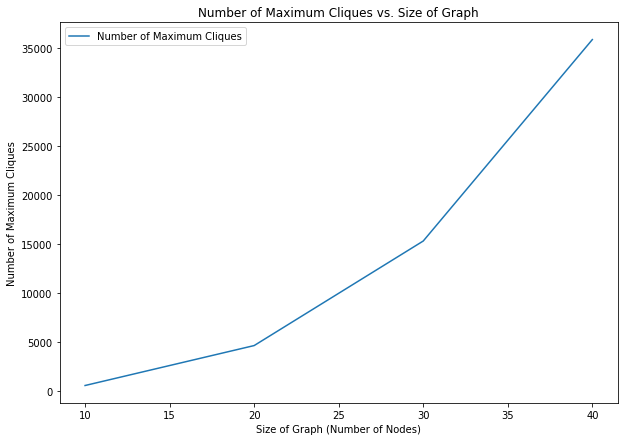

In [48]:
plt.plot(graph_size_dist["Nodes"], graph_size_dist["Number of Maximum Cliques"], label = "Number of Maximum Cliques")

plt.xlabel('Size of Graph (Number of Nodes)')
plt.ylabel('Number of Maximum Cliques')
plt.title('Number of Maximum Cliques vs. Size of Graph')
plt.legend()

plt.show()

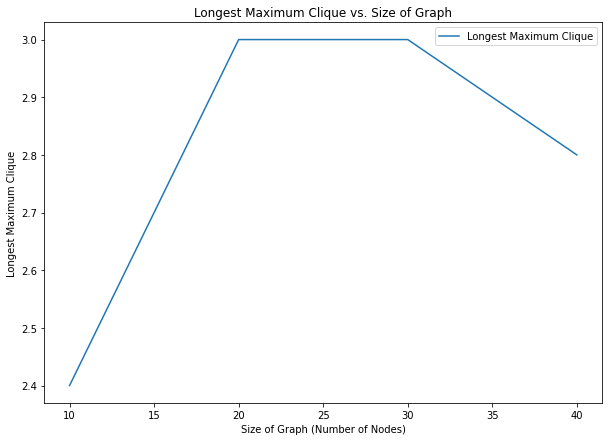

In [49]:
plt.plot(graph_size_dist["Nodes"], graph_size_dist["Longest Maximum Clique"], label = "Longest Maximum Clique")

plt.xlabel('Size of Graph (Number of Nodes)')
plt.ylabel('Longest Maximum Clique')
plt.title('Longest Maximum Clique vs. Size of Graph')
plt.legend()

plt.show()

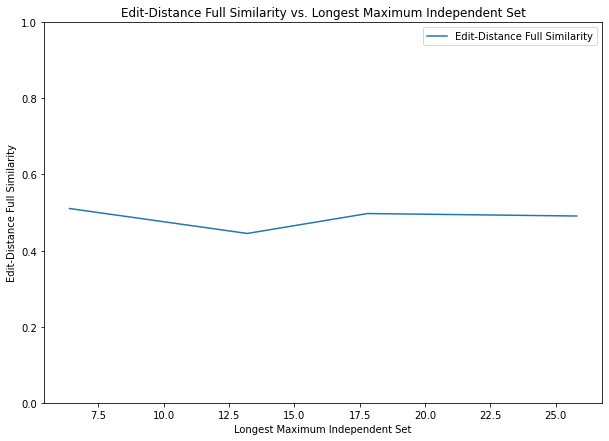

In [50]:
plt.plot(graph_size_dist["Longest Maximum Independent Set"], graph_size_dist["Edit-Distance Full Similarity"], label = "Edit-Distance Full Similarity")

plt.xlabel('Longest Maximum Independent Set')
plt.ylabel('Edit-Distance Full Similarity')
plt.title('Edit-Distance Full Similarity vs. Longest Maximum Independent Set')
plt.legend()
plt.ylim(0, 1)

plt.show()

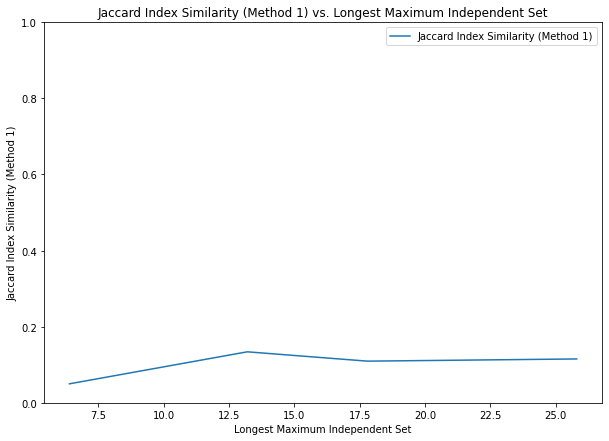

In [51]:
plt.plot(graph_size_dist["Longest Maximum Independent Set"], graph_size_dist["Jaccard Index Similarity (Method 1)"], label = "Jaccard Index Similarity (Method 1)")

plt.xlabel('Longest Maximum Independent Set')
plt.ylabel('Jaccard Index Similarity (Method 1)')
plt.title('Jaccard Index Similarity (Method 1) vs. Longest Maximum Independent Set')
plt.legend()
plt.ylim(0, 1)

plt.show()

### Distribution of Similarity Over Random Graphs of Constant Size

In [52]:
sim_dist = pd.read_csv("Data/sim-dist-10-30-45.csv")
sim_dist = sim_dist.rename(columns={"Edit-Distance Immediate Similarity Averages": "Edit-Distance Immediate Similarity", 
                 "Edit-Distance Full Similarity Averages": "Edit-Distance Full Similarity",
                "Jaccard Index Similarity (Method 1) Averages": "Jaccard Index Similarity (Method 1)"})

In [53]:
sim_dist.head()

,Unnamed: 0,Edit-Distance Immediate Similarity,Edit-Distance Full Similarity,Jaccard Index Similarity (Method 1),Jaccard Index Similarity (Method 2) Averages,Longest Maximum Independent Set,Number of Maximum Cliques,Longest Maximum Clique
0,0,0.771123,0.507950,0.130620,0.270659,19.0,15660.0,3.0
1,1,0.710505,0.427227,0.128153,0.366689,18.0,14790.0,3.0
2,2,0.650641,0.520339,0.067644,0.122713,19.0,16530.0,2.0
3,3,0.713761,0.457566,0.148226,0.653264,17.0,13920.0,2.0
4,4,0.677776,0.508908,0.081907,0.161411,18.0,16530.0,3.0


In [54]:
sim_dist["Edit-Distance Immediate Similarity"] = 1 - sim_dist["Edit-Distance Immediate Similarity"]
sim_dist["Edit-Distance Full Similarity"] = 1 - sim_dist["Edit-Distance Full Similarity"]

(0.0, 1.0)

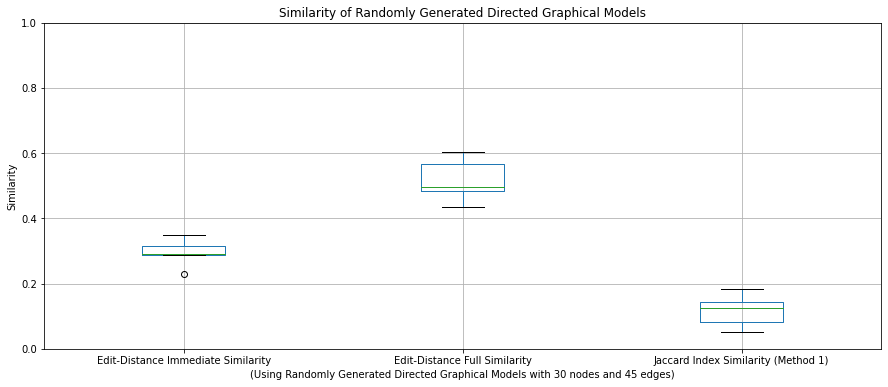

In [55]:
sim_dist.boxplot(column=["Edit-Distance Immediate Similarity", "Edit-Distance Full Similarity", 'Jaccard Index Similarity (Method 1)'], figsize = (15,6), return_type = "axes")

plt.ylabel("Similarity")
plt.xlabel("(Using Randomly Generated Directed Graphical Models with 30 nodes and 45 edges)")
plt.title("Similarity of Randomly Generated Directed Graphical Models")
plt.ylim(0, 1)